# Test: Clustering vs. Labeln vs. 1D-Fit

- create 3 different rois
- find electron object with different algorithms 
- timeit, compare

In [32]:
# Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import regionprops
from scipy.ndimage import label, median_filter, find_objects
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit

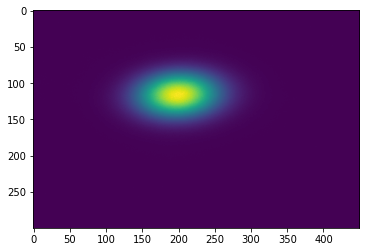

In [33]:
# create roi
with open('D:\\HZB\\Camera_Data\\mls13\\1test.npy', 'rb') as f:
        data = np.load(f)
data = data.reshape(1456, 1936)
roi = data[(slice(600, 900, None),
            slice(800, 1250, None))]
plt.imshow(roi, cmap='viridis')
plt.show()

### Clustering

In [34]:
edge_x = roi.shape[1]
edge_y = roi.shape[0]
x_values = np.repeat(np.array([range(0, edge_x)]), edge_y, axis=0)
y_list = []
for i in range(0, edge_y):
    y_list.append([i] * edge_x)
y_values = np.array(y_list)

x_werte = np.array(x_values.flatten()) / edge_x
y_werte = np.array(y_values.flatten()) / edge_y
z_werte = np.array(roi.flatten()) 
#print(x_werte)
#print(y_werte)
#print(z_werte)

cluster_data = np.stack((x_werte, y_werte, z_werte), axis=-1)
print(cluster_data)

[[0.00000000e+00 0.00000000e+00 1.51000000e+02]
 [2.22222222e-03 0.00000000e+00 1.69000000e+02]
 [4.44444444e-03 0.00000000e+00 1.78000000e+02]
 ...
 [9.93333333e-01 9.96666667e-01 1.49000000e+02]
 [9.95555556e-01 9.96666667e-01 1.33000000e+02]
 [9.97777778e-01 9.96666667e-01 1.62000000e+02]]


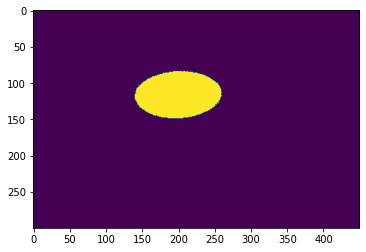

In [35]:
def cluster_KMeans (np_a, n_cluster):
    kmeans = KMeans(n_clusters=n_cluster, random_state=2)
    kmeans_labels = kmeans.fit(np_a).labels_
    return kmeans_labels

cluster_result = cluster_KMeans(cluster_data, 2)

final_cluster = cluster_result.reshape(roi.shape)
plt.imshow(final_cluster, cmap='viridis')
plt.show()

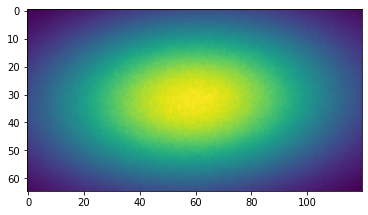

In [36]:
region = regionprops(final_cluster)[0]
miny, minx, maxy, maxx = region.bbox
object = roi[(slice(miny, maxy, None),
                       slice(minx, maxx, None))]
plt.imshow(object)
plt.show()

### Labeln

708.7578666666667
1


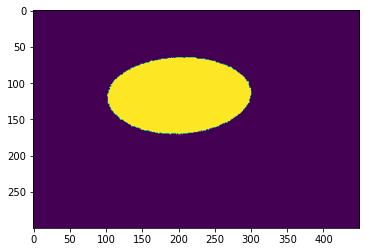

In [37]:
def define_threshold(data):
    classif = GaussianMixture(n_components=1)
    classif.fit(data.reshape((data.size, 1)))
    threshold = np.mean(classif.means_)
    return threshold

threshold = define_threshold(roi)
print(threshold)

med_filt_data = median_filter(roi, size=2)

# threshold filter
thr_filt_data = med_filt_data > threshold

# labeln
labeled_data, num_label = label(thr_filt_data)
print(num_label)

plt.imshow(labeled_data)
plt.show()

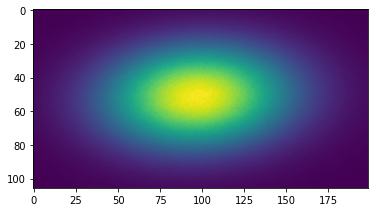

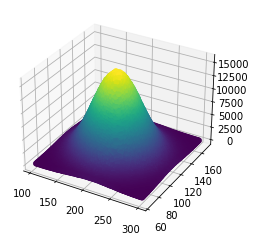

In [38]:
# find object
frames = find_objects(labeled_data)
object_label = roi[frames[0]]

plt.imshow(object_label)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(x_values[frames[0]], y_values[frames[0]], object_label, c=object_label, cmap='viridis')

### Compare

In [43]:
def my_cluster(x, y, z):
    cluster_data = np.stack((x, y, z.flatten()), axis=-1)
    cluster_result = cluster_KMeans(cluster_data, 2)

    final_cluster = cluster_result.reshape(z.shape)
    return final_cluster
   
%timeit result_data = my_cluster(x_werte, y_werte, roi)


412 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit result_data = my_cluster(x_werte, y_werte, data)

In [45]:
def my_label(z):
    med_filt_data = median_filter(roi, size=2)

# threshold filter
    thr_filt_data = med_filt_data > threshold

# labeln
    labeled_data, num_label = label(thr_filt_data)
    return labeled_data

%timeit result_data = my_label(roi)


4.76 ms ± 90.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


deutlicher zeitlicher unterschied

obwohl label median filter braucht
